### **ΟΜΑΔΑ 40**
* Μαριαλένα Βαγγελάτου (ΑΜ: 03118141)
* Νικόλαος Μπλέτσας (ΑΜ: 03118899)
* Γεώργιος Τζουμανέκας (ΑΜ: 03118095)


# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.0 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import nltk
import sys
import scipy as sp
from time import time 
import re
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
import string
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 40

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Ernest Goes to Africa']
['"Family Film",  "Comedy of Errors",  "Adventure Comedy",  "Comedy",  "Slapstick"']
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

Για αρχή εκτυπώνουμε αρκετά στοιχεία απο τον πίνακα corpus για να τα μελετήσουμε. Ενδεικτικά το πρώτο:

In [ ]:
print(titles[0])
print(corpus[0])

["Les Amours d'Astrée et de Céladon"]
Inspired by L'Astrée a 17th century major work by Honoré d'Urfé about a shepherd, Céladon, who is madly in love with the beautiful Astrée, who flees from him, convinced of his infidelity. The story is set in fifth-century druidic Gaul. It was filmed in Auvergne at Les Gorges de la Sioulle in May 2006.


**Καθαρισμός δεδομένων**

Για κάθε corpus:

1. Θα αφαιρέσουμε όλους τους ειδικούς χαρακτήρες (όπως ', -, ", ., & κτλ.).
2. Όλοι οι χαρακτήρες έγιναν πεζοί, ώστε κάθε λέξη του dataset να μπορεί να γραφτεί με έναν μόνο τρόπο.
3. Αφαιρέθηκαν οι λέξεις που ανήκουν στο έτοιμο λεξικό stopwords.words('english') όπως and, or κτλ. διότι δεν προσφέρουν ουσιαστική πληροφορία και αφαιρέθηκαν οι λέξεις που ανήκουν στο λεξικό custom_stopwords που δημιουργήθηκε βάσει της μελέτης του περιεχομένου των corpus. Σε αυτό το λεξικό προσθέσαμε λέξεις που είναι συχνές σε αυτά τα corpus όμως δεν προσφέρουν ουσιαστική πληροφορία πχ movie, film κτλ.
4. Έγινε lemmatization των λέξεων αλλά όχι stemming, ώστε να μπορούν οι λέξεις των corpus να ταυτιστούν με λέξεις από τα προεκπαιδευμένα μοντέλα εμφυτευμάτων.
5. Αφαιρέθηκαν οι λέξεις μήκους ενός ή δύο χαρακτήρων μιας και δεν προσφέρουν ουσιαστική πληροφορία.

In [ ]:
nltk.download('punkt') # χρειάζεται για το tokenizer
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

custom_stopwords = ['able', 'also', 'anyway', 'arrive', 'begin', 'character', 'character',
                    'eight', 'eighth', 'end', 'episode', 'even', 'every', 'fifth', 'film',
                    "film's", 'first', 'five', 'four', 'fourth', 'full', 'get', 'give', 'head',
                    'later', 'like', 'main', 'make', 'making', 'movie', 'much', "n't", 'nine',
                    'nineth', 'often', 'one', 'open', 'participating', 'performance', 'second',
                    'section', 'see', 'set', 'seven', 'seventh', 'sit', 'six', 'sixth', 'start',
                    'start', 'still', 'take', 'tell', 'ten', 'tenth', 'third', 'three', 'time', 'today', 'two']

In [ ]:
def thorough_filter(words):
    filt_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filt_words.append(word)
    return filt_words

In [ ]:
def preprocess_corpus(corpus):
    words = nltk.word_tokenize(corpus.lower())
    filtered_words = [word for word in words if word not in list(string.punctuation) + stopwords.words('english') + custom_stopwords]
    filtered_words = thorough_filter(filtered_words) #removal of words that we don't want

    stemmed_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words] #lemmatizing

    stemmed_words = [word for word in stemmed_words if (len(word) >= 3)] #words of 1 or 2 characters removal
    cnt = collections.Counter(stemmed_words)

    return(stemmed_words,cnt)

In [ ]:
preprocessed_documents = []
prep_doc_cnt = []
for cor in corpus:
    cor = re.sub("[^A-Za-z]+", ' ', cor)
    (preprocessed_documents_instance, prep_doc_cnt_instance) = preprocess_corpus(cor)
    preprocessed_documents.append(preprocessed_documents_instance)
    prep_doc_cnt.append(prep_doc_cnt_instance)

In [ ]:
new_corpus = []

for doc in preprocessed_documents:
    new_corpus.append(' '.join(doc))

joblib.dump(new_corpus, 'new_corpus.pkl')

['new_corpus.pkl']

Παρουσιάζουμε ένα ενδεικτικό corpus για να δούμε τις αλλαγές:

In [ ]:
print(corpus[13])
print(new_corpus[13])

Dr. Asira is faced with the contrast between Western medicine and traditional East African spirituality when a woman, Samehe, who is admitted to a psychiatric hospital, claims to be under the care of Maangamizi, a mysterious ancestor / shaman.
asira faced contrast western medicine traditional east african spirituality woman samehe admitted psychiatric hospital claim care maangamizi mysterious ancestor shaman


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(new_corpus)
corpus_tf_idf_plain = vectorizer.transform(new_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
print(corpus_tf_idf_plain.shape)

(5000, 42225)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
#the info of the movie we are asked to present
def movie_info(movie_id):
    print("Movie ID:", movie_id,"-","Title:", titles[movie_id][0], "\n")
    print("Category: ", categories[movie_id][0], "\n")
    print("Corpus of movie: ", corpus[movie_id], "\n")

In [ ]:
def content_recommender(target_movie,max_recomendations,corpus_type):
    corpus_type_arr = corpus_type.toarray()
    distances = np.zeros((corpus_type_arr.shape[0]))
    for i in range(corpus_type_arr.shape[0]): 
        distances[i] = sp.spatial.distance.cosine(corpus_type_arr[target_movie], corpus_type_arr[i])
    similarity = np.argsort(distances)[1:max_recomendations + 1]

    print("\033[1m" + "Target Movie:" + "\033[0m")
    movie_info(target_movie)
    print("\n\033[1m" + "Recommendations:" + "\033[0m")
    for i,id in enumerate(similarity):
        print("\x1B[4m" + "Recommendation Νο. ", i + 1, ":" + "\x1B[0m", sep='')
        movie_info(id)

In [ ]:
tester_ids = [4, 95, 141, 899, 1313]

for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_plain)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
Movie ID: 4 - Title: Yakuza Weapon 

Category:  "Action",  "Fantasy",  "Science Fiction",  "Martial Arts Film",  "Japanese Movies" 

Corpus of movie:  Shozo Iwaki  is a strong fighter with a strong disregard for his own safety during fights by shrugging off all wounds and damage. He has a falling out with his father, the Boss Yakuza Kenzo Iwaki  and spends years in the South American jungle fighting mercenaries. After a battle against opposing soldiers, Shozo is found by Red Tiger and his team, a Japanese special agent who informs him that his father was assassinated. Shozo returns home to find his old hideout is now a sleazy loan shark operation run by a former junior lieutenant in the Yakuza, and a rival Yakuza boss, Kurawaki  who is double crossing him and trying to unite the other clans under his control. Shozo is then ambushed by his old Yakuza flame, Sister Nayoko  under the perception that he abandoned her when he left for South America. Upset with this turn of eve

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
new_vectorizer = TfidfVectorizer(min_df=0.0005, max_df=0.3)
new_vectorizer.fit(new_corpus)
corpus_tf_idf_new = new_vectorizer.transform(new_corpus)

joblib.dump(corpus_tf_idf_new, 'corpus_tf_idf_new.pkl')

['corpus_tf_idf_new.pkl']

<font color = "magenda">**Παρατηρήσεις**</font>

Όπως αναφέρεται και στις οδηγίες, η προεπεξεργασία που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά έγινε πιο πάνω. Σε αυτό το σημείο έγινε η προεπεξεργασία που απαιτεί γνώση των συνολικών στατιστικών της συλλογής. Έτσι έγιναν οι ακόλουθες επιλογές παραμέτρων:

* Η παράμετρος max_df αφαιρεί λέξεις που έχουν συχνότητα πάνω από ένα threshold. Προσπαθώντας να μειώσουμε όσο γίνεται τις διαστάσεις δοκιμάσαμε τιμές από 0.1 και πάνω και παρατηρήσαμε ότι για πολύ μικρές τιμές το σύστημα συστάσεων δεν απέδιδε καλά. Παρόλα αυτά από την τιμή 0.3 και πάνω δεν υπήρχε διαφορά στην επίδοση έτσι επιλέξαμε αυτή την τιμή για την παράμετρο.

* Η παράμετρος min_df αφαιρεί λέξεις που έχουν συχνότητα κάτω από ένα threshold. Προσπαθώντας να μειώσουμε όσο γίνεται τις διαστάσεις δοκιμάσαμε τιμές από 0.01 και κάτω και παρατηρήσαμε ότι για μεγάλες τιμές το σύστημα συστάσεων δεν απέδιδε καλά. Παρόλα αυτά από την τιμή 0.0005 και κάτω δεν υπήρχε διαφορά στην επίδοση έτσι επιλέξαμε αυτή την τιμή για την παράμετρο.


*Note: Όσον αφορά το cherry και το nir picking η συντριπτική πλειοψηφία των ταινιών του dataset που δόθηκαν ήταν ταινίες τις οποίες δεν γνωρίζαμε και λόγω του μεγάλου μεγέθους του dataset το να αξιολογήσουμε το σύστημα οπτικά ήταν αρκετά δύσκολο. Ωστόσο παρακάτω παρουσιάζουμε παραδείγματα που οι ταινίες που προτείνει ο recommender είναι καλά ή κακά παραδείγματα προτάσεων.*

<font color=magenda>**Cherry picking** </font>

In [ ]:
#cherry picking
cherry_ids = [18, 1665, 2689, 3405, 4889]

for tester_id in cherry_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_new)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
Movie ID: 18 - Title: He Has Nothing But Kung Fu 

Category:  "Action Thrillers",  "Action",  "Martial Arts Film",  "Chinese Movies" 

Corpus of movie:  Yung Wang Yu stars as Sha Shan, a crafty con-artist who uses his wiles to trick money out of the unsuspecting public while also avoiding those he enrages. One particular escapade sees him make a fool out of a local gang member who also loses a considerable amount of money in the process. Unfortunately this sets into motion a series of events which sees the shamed victim sending his vicious gang out to exact revenge and the wiley young trickster with no option but to run away. During these events, he also meets a dazed amnesiac  he proves himself to be a formidable fighter shortly afterwards and helps his new friend out in a few close escapes from the antagonists. The mystery man - who is actually Ka Yuen, the missing son of a wealthy Admiral - uses his exceptional fighting prowess for good, defeating the oppressive enemie

<font color=magenda>**Nir picking**</font>

In [ ]:
#nir picking
nir_ids = [58, 150, 300, 4124, 4587]

for tester_id in nir_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_new)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
Movie ID: 58 - Title: The Emperor of Capri 

Category:  "Comedy" 

Corpus of movie:  Sonia, a beautiful gold digger, mistakes Antonio, a waiter in a Neapolitan hotel, for the Arab prince Bey of Agapur and makes an appointment with him for the following day in Capri. Antonio goes there behind his wife and mother in law's back. Due to a lucky series of circumstances he really does becomes the prince of the island. 


Recommendations:
Recommendation Νο. 1:
Movie ID: 1904 - Title: Luna de Miel 

Category:  "Romantic drama",  "Romance Film",  "Drama",  "Musical Drama" 

Corpus of movie:  Ballet dancer Anna Cato  has just given up the ballet to marry Australian farmer Kit Kelly . They are touring Spain in their open top Bentley for their honeymoon before going to live on the sheep station that Kit runs in Australia. An American car races past them at high speed but it soon has to stop to change a burst tyre. The car is driven by the famous Spanish dancer Antonio and his wife Ro

#### <font color="magenda"> **Πλεονεκτήματα και μειονεκτήματα ενός TF-IDF recommendation system** </font>

**Πλεονεκτήματα**

* Είναι απλό στη υλοποίηση

* Μπορεί να αφομοιώσει καινούργιες ταινίες με καινούργιες περιγραφές χωρίς να απαιτεί πολλούς επιπλέον υπολογισμούς ή επιπλέον στοιχεία (όπως για παράδειγμα θα απαιτούσε ένας recommender που βασίζεται στις βαθμολογίες των χρηστών)

* Μπορούμε εύκολα να υπολογίσουμε την ομοιότητα μεταξύ δυό ταινιών

**Μειονεκτήματα**

* Περιγραφές ταινιών που περιέχουν παρόμοιες λέξεις (που δεν έχουν αφαιρεθεί με το custom_dictionary) ενδέχεται να θεωρηθούν παρόμοιες ενώ στην ουσία οι ταινίες να είναι εντελώς διαφορετικές. Γιαυτό ήταν αρκετά πιο εύκολο να βρούμε ταινίες για το nir picking.

* Δεν συνυπολογίζει το γεγονός ότι κάποιες περιγραφές ταινιών είναι πολύ αναλυτικές ενώ κάποιες άλλες περιγραφές είναι πολύ επιγραμματικές

* Η θέση της λέξης μέσα στην πρόταση δεν επηρεάζει το αποτέλεσμα

* Δεν προσδίδεται βάρος σε πιο σημαντικές λέξεις. Για παράδειγμα λέξεις που είναι ενδεικτικές για το είδος μίας ταινίας, όπως πχ "murder", "killer", "victim" αντιμετωπίζονται με τον ίδιο τρόπο όπως άλλες λέξεις που δεν προσφέρουν ουσιαστική πληροφορία

* Αδυνατεί να ανιχνεύσει διαφορετικές έννοιες για την ίδια λέξη

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
#!pip install -U gensim
import gensim.downloader

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
model_1 = gensim.downloader.load("glove-wiki-gigaword-200")

In [ ]:
model_2 = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
    w2v = []

    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus).toarray()
    vocabulary = vectorizer.vocabulary_

    unknown_words = 0

    for i,cor in enumerate(corpus):
        cor_list = cor.split(' ')
        nom = 0
        denom = 0
        for word in cor_list:
            if word in vectors:
              nom += corpus_tf_idf[i][vocabulary[word]] * vectors[word]
              denom += corpus_tf_idf[i][vocabulary[word]]
            else:
              unknown_words += 1
        w2v.append(nom / denom)
    print("Number of unknown words:",unknown_words)
    return sp.sparse.csr_matrix(np.array(w2v))

In [ ]:
corpus_w2v_1 = build_tfw2v(new_corpus, model_1, 200)

Number of unknown words: 13256


In [ ]:
tester_ids = [4, 95, 141, 899, 1313, 1665]

for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_w2v_1)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
Movie ID: 4 - Title: Yakuza Weapon 

Category:  "Action",  "Fantasy",  "Science Fiction",  "Martial Arts Film",  "Japanese Movies" 

Corpus of movie:  Shozo Iwaki  is a strong fighter with a strong disregard for his own safety during fights by shrugging off all wounds and damage. He has a falling out with his father, the Boss Yakuza Kenzo Iwaki  and spends years in the South American jungle fighting mercenaries. After a battle against opposing soldiers, Shozo is found by Red Tiger and his team, a Japanese special agent who informs him that his father was assassinated. Shozo returns home to find his old hideout is now a sleazy loan shark operation run by a former junior lieutenant in the Yakuza, and a rival Yakuza boss, Kurawaki  who is double crossing him and trying to unite the other clans under his control. Shozo is then ambushed by his old Yakuza flame, Sister Nayoko  under the perception that he abandoned her when he left for South America. Upset with this turn of eve

In [ ]:
corpus_w2v_2 = build_tfw2v(new_corpus, model_2, 300)

Number of unknown words: 36602


In [ ]:
tester_ids = [4, 95, 141, 899, 1313, 1665]

for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_w2v_2)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
Movie ID: 4 - Title: Yakuza Weapon 

Category:  "Action",  "Fantasy",  "Science Fiction",  "Martial Arts Film",  "Japanese Movies" 

Corpus of movie:  Shozo Iwaki  is a strong fighter with a strong disregard for his own safety during fights by shrugging off all wounds and damage. He has a falling out with his father, the Boss Yakuza Kenzo Iwaki  and spends years in the South American jungle fighting mercenaries. After a battle against opposing soldiers, Shozo is found by Red Tiger and his team, a Japanese special agent who informs him that his father was assassinated. Shozo returns home to find his old hideout is now a sleazy loan shark operation run by a former junior lieutenant in the Yakuza, and a rival Yakuza boss, Kurawaki  who is double crossing him and trying to unite the other clans under his control. Shozo is then ambushed by his old Yakuza flame, Sister Nayoko  under the perception that he abandoned her when he left for South America. Upset with this turn of eve

#### <font color=magenda> **Παρατηρήσεις** </font>
**Σύγκριση των δύο W2V recommenders με τους tfidf**

* Για τις ταινίες που οι tfidf δεν επέστρεφαν καλά αποτελέσματα, φαίνεται ότι ούτε οι W2V αποδίδουν τόσο καλά. Για παράδειγμα οι recommenders προτείνουν για την ταινία "Movie Movie" (ένα κωμικό μιούζικαλ) ως πρώτες επιλογές ταινίες θρίλερ ή ταινίες βουβού κινηματογράφου.

* Υπάρχουν περιπτώσεις που οι W2V δεν δίνουν τόσο ικανοποιητικά αποτελέσματα αλλά δίνουν αρκετά καλύτερα αποτελέσματα από ότι οι tfidf. Χαρακτηριστικό παράδειγμα είναι τα αποτελέσματα για την ταινία  "Star Trek IV: The Voyage Home" όπου ο tfidf δίνει εντελώς άσχετα αποτελέσματα.

* Υπάρχουν περιπτώσεις που οι W2V δεν επιστρέφουν καλά αποτελέσματα, ενώ οι tfidf επέστρεψαν καλύτερα. Για παράδειγμα στην ταινία "Scooby-Doo and the Witch's Ghost" που οι tfidf επιστρέφουν μια ακόμα ταινία Scooby Doo (επείδη αναγνωρίζουν το ίδιο όνομα του χαρακτήρα) ενώ οι W2V επιστρέφουν ταινίες τρόμου.

* Για τις ταινίες που οι tfidf επέστρεφαν καλά αποτελέσματα, φαίνεται ότι και οι W2V αποδίδουν αρκετά καλά. Συγκεκριμένα, προτείνουν είτε τις ταινίες που πρότειναν και οι tfidf αλλά και άλλες ταινίες που είναι επίσης σχετικές. Αυτό φαίνεται στα αποτελέσματα για την ταινία "The Great Escape" που προτείνονται αντίστοιχες πολεμικές ταινίες.

* Οι W2V recommenders απαιτούν σημαντικό χρόνο για να κατεβούν τα προεκπαιδευμένα εμφυτεύματα (σχεδόν 10 λεπτά και οι δύο). Ωστόσο οι διαστάσεις των corpus είναι μικρότερες. Συγκεκριμένα ο τελικός tfidf recommender δίνει διαστάσεις 5000 x 16559, ενώ οι W2V δίνουν διαστάσεις 5000 x 200 και 5000 x 300.

**Σύγκριση μεταξύ των δύο W2V recommenders**

* Οι δύο recommenders συνήθως εμφανίζουν άλλα αποτελέσματα αλλά μερικές φορές φαίνεται να επιστρέφουν παρόμοια αποτελέσματα με διαφορετική σειρά. Γενικότερα φαίνεται να υπάρχει κάποια συμφωνία μεταξύ των δύο W2V recommenders, τουλάχιστον στο είδος των ταινιών που προτείνονται.

* Ο recommender που χρησιμοποιεί το προεκπαιδευμένο μοντέλο εμφυτευμάτων glove-wiki-gigaword-200 έχει μικρότερη διάσταση εμφυτευμάτων και μικρότερο μέγεθος από αυτόν που χρησιμοποιεί το προεκπαιδευμένο μοντέλο εμφυτευμάτων fasttext-wiki-news-subwords-300. Παρόλα αυτά έχει πολύ περισσότερες κοινές λέξεις με αυτές που εμφανίζονται στις περιγραφές από τον δεύτερο. Για την ακρίβεια, ο πρώτος δεν αναγνωρίζει 13256 λέξεις ενώ ο δεύτερος δεν αναγνωρίζει 36602.

## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(corpus_tf_idf_new, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

total 18M
-rw-r--r-- 1 root root 6.0M Dec 19 16:48 corpus_tf_idf_new.pkl
-rw-r--r-- 1 root root 6.0M Dec 19 16:59 corpus_tf_idf.pkl
-rw-r--r-- 1 root root 5.4M Dec 19 16:48 new_corpus.pkl
drwxr-xr-x 1 root root 4.0K Dec 16 00:01 sample_data


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set = build_final_set(corpus_tf_idf_new)
final_set.shape

(5000, 16557)

**Μείωση διαστατικότητας με χρήση PCA**

Το πιο πάνω μέγεθος είναι πολύ μεγάλο με αποτέλεσμα η εκπαίδευση του SOM να διαρκεί αρκετή ώρα. Για αυτό το λόγο θα κάνουμε μια μείωση της διαστατικότητας με τη χρήση pca για να μειωθούν σημαντικά οι διαστάσεις χωρίς να χαθεί σημαντική πληροφορία και να επιταγχύνουμε την διαδικασία.

In [ ]:
pca = PCA(n_components = 550)
PCA_corpus = pca.fit_transform(corpus_tf_idf_new.toarray())
PCA_corpus_sparse = sp.sparse.csr_matrix(PCA_corpus)
corpus_tf_idf_new_pca = PCA_corpus_sparse

In [ ]:
final_set = build_final_set(corpus_tf_idf_new_pca)
final_set.shape

(5000, 872)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [ ]:
f_set = build_final_set(corpus_tf_idf_new_pca, 2000)
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som.train(f_set, epochs = 100)

CPU times: user 1min 6s, sys: 327 ms, total: 1min 6s
Wall time: 50.5 s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus = som.bmus
print(bmus.shape)

(2000, 2)


In [ ]:
ubmus, indices = np.unique(bmus, return_inverse = True, axis = 0)
#print(ubmus)
print(ubmus.shape)
print(indices)
print(indices.shape)

(90, 2)
[16 16  6 ... 13 31 69]
(2000,)



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

k = 20

algorithm = KMeans(n_clusters = k)
som.cluster(algorithm = algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
joblib.dump(som, 'som.pkl')

['som.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



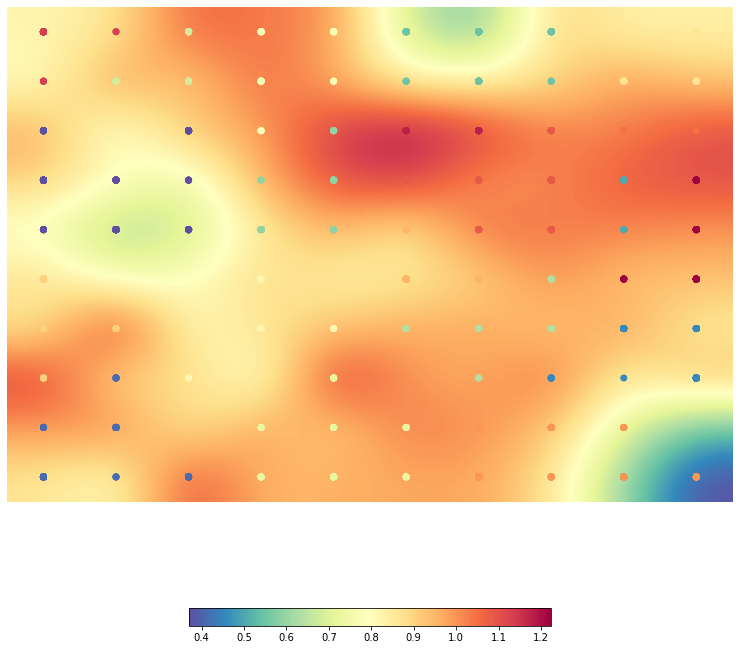

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>


In [ ]:
print(som.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13)))

In [ ]:
clusters = som.clusters
print(clusters)

[[17 17  7  9  9  4  4  4 11 11]
 [17  7  7  9  9  4  4  4 11 11]
 [ 0  0  0  9  5 18 18 16 15 15]
 [ 0  0  0  5  5 16 16 16  3 19]
 [ 0  0  0  5  5 13 16 16  3 19]
 [12  0  0 10 13 13 13  6 19 19]
 [12 12 10 10 10  6  6  6  2  2]
 [12  1 10 10  8  8  6  2  2  2]
 [ 1  1  1  8  8  8 14 14 14 14]
 [ 1  1  1  8  8  8 14 14 14 14]]


In [ ]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) } #ascending sorting
print(cl_info_sorted)

{3: 2, 15: 2, 18: 2, 7: 3, 17: 3, 11: 4, 12: 4, 13: 4, 19: 4, 2: 5, 5: 5, 6: 5, 9: 5, 4: 6, 10: 6, 16: 6, 1: 7, 8: 8, 14: 8, 0: 11}



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(IDs):
    total_categories = []
    for movie_id in IDs: 
        movie_categories = categories[movie_id][0].split(",") 
        for i in range(len(movie_categories)):           
            total_categories.extend([movie_categories[i].strip()])
    unique_categories, counts = np.unique(total_categories, return_counts=True)
    largest_categories_indexes = np.argsort(counts)[::-1]
    result = [(unique_categories[index],counts[index]) for index in largest_categories_indexes]  
    print("Overall Cluster Genres stats:")
    print(result)
    return result  

In [ ]:
#η συνάρτηση θα βρίσκει το cluster από το SOM χάρτη
def print_cluster_neurons_movies_report(cluster_number, som, ubmus):
    row_indexes, column_indexes = np.where(som.clusters==cluster_number) 
    cluster_bmus = np.column_stack((column_indexes,row_indexes)) 
    cluster_bmus_indices  = [] 
    for cluster_bmu in cluster_bmus:
        if (ubmus == cluster_bmu).all(axis=1).any():
            bmus_number = np.where(np.all(cluster_bmu==ubmus,axis=1))[0][0]
            cluster_bmus_indices.append(bmus_number)
    return cluster_bmus

In [ ]:
import itertools

def neuron_movies_report(som,neurons):
    cluster_movies_ids = []
    for neuron in neurons: 
        if (som.bmus == neuron).all(axis=1).any():
            cluster_movies_ids.append(np.where(np.all(som.bmus==neuron,axis=1))[0]) 
    return list(itertools.chain.from_iterable(cluster_movies_ids))

In [ ]:
k = 20
for i in range(k):
    print("Cluster id:", i)
    print("Number of movies in cluster is:", len(neuron_movies_report(som,print_cluster_neurons_movies_report(i,som,ubmus))))
    print_categories_stats(neuron_movies_report(som,print_cluster_neurons_movies_report(i,som,ubmus)))
    print('\n')

Cluster id: 0
Number of movies in cluster is: 248
Overall Cluster Genres stats:
[('"Short Film"', 47), ('"Documentary"', 45), ('"Comedy film"', 26), ('"Silent film"', 23), ('"Japanese Movies"', 19), ('"Western"', 16), ('"Musical"', 15), ('"War film"', 13), ('"Indie"', 12), ('"Science Fiction"', 11), ('"Crime Fiction"', 10), ('"Black-and-white"', 9), ('"Biography"', 9), ('"Culture & Society"', 8), ('"Family Film"', 7), ('"Music"', 7), ('"Chinese Movies"', 6), ('"Children\'s/Family"', 6), ('"Fantasy"', 6), ('"Action/Adventure"', 6), ('"Romantic comedy"', 6), ('"Rockumentary"', 6), ('"History"', 5), ('"Comedy-drama"', 5), ('"Social issues"', 4), ('"Mystery"', 4), ('"Animated cartoon"', 4), ('"Children\'s Fantasy"', 4), ('"Bollywood"', 3), ('"Romantic drama"', 3), ('"Children\'s"', 3), ('"Anime"', 3), ('"Historical fiction"', 3), ('"Historical drama"', 3), ('"Parody"', 3), ('"Time travel"', 2), ('"Television movie"', 2), ('"Biographical film"', 2), ('"Spy"', 2), ('"Cult"', 2), ('"Family-Or


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## <font color=orange>**Δοκιμές**</font>


* Για set με 2500 ταινίες

In [ ]:
f_set_2500 = build_final_set(corpus_tf_idf_new_pca, 2500)

**Για χάρτη 20x20 με 100 epochs:**

In [ ]:
n_rows, n_columns = 20, 20
som_20x20_2500 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_20x20_2500.train(f_set_2500, epochs = 100)

CPU times: user 5min 58s, sys: 1.7 s, total: 6min
Wall time: 3min 51s


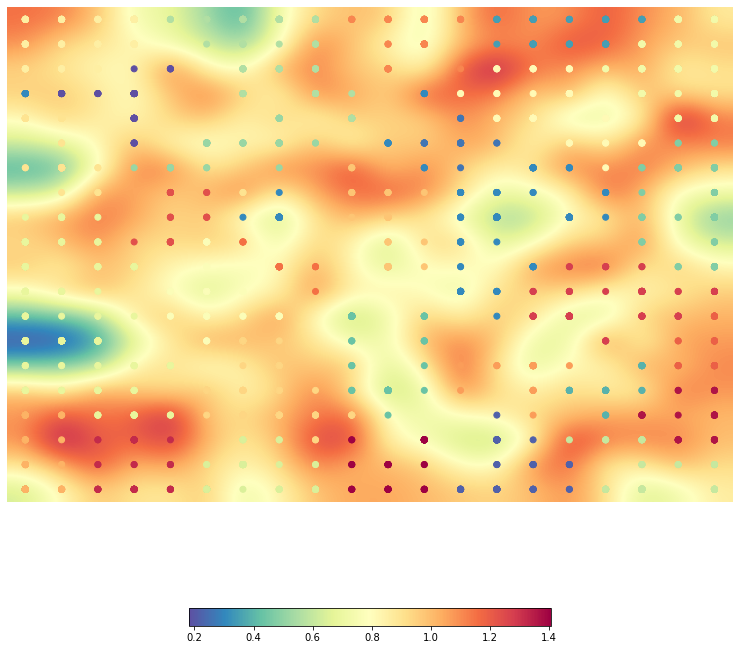

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_20x20_2500.cluster(algorithm = algorithm)
som_20x20_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_20x20_30_2500 = som_20x20_2500.clusters

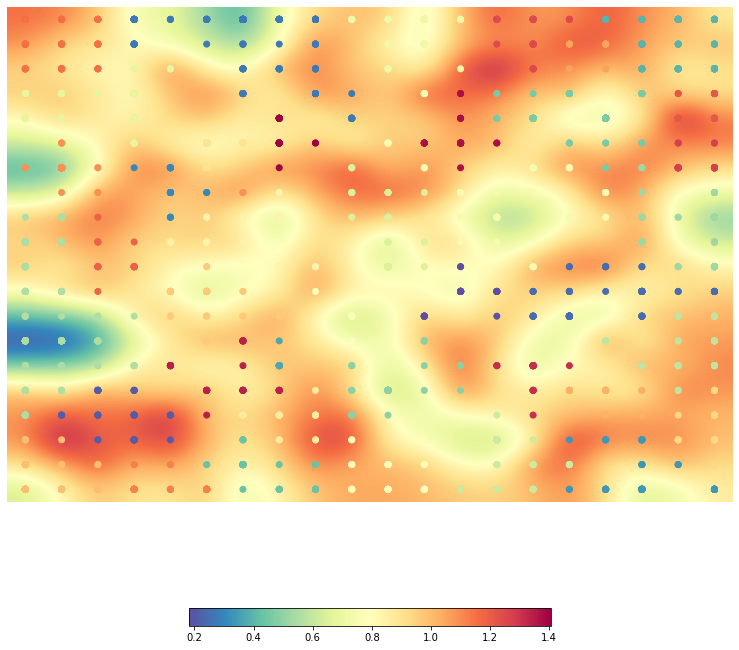

In [ ]:
algorithm = KMeans(n_clusters = 40)
som_20x20_2500.cluster(algorithm = algorithm)
som_20x20_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_20x20_40_2500 = som_20x20_2500.clusters

**Για χάρτη 30x30 με 100 epochs:**

In [ ]:
n_rows, n_columns = 30, 30
som_30x30_2500 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_30x30_2500.train(f_set_2500, epochs = 100)

CPU times: user 13min 35s, sys: 3.61 s, total: 13min 39s
Wall time: 7min 57s


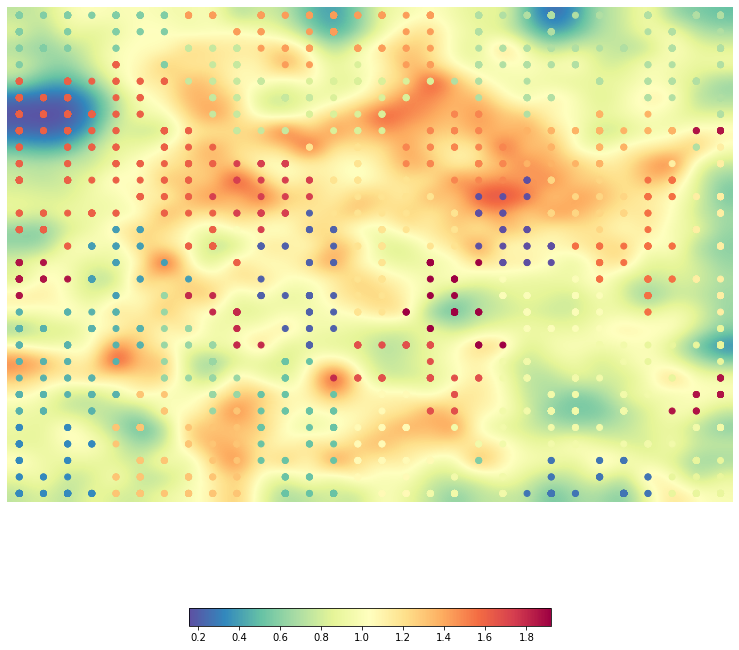

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_30x30_2500.cluster(algorithm = algorithm)
som_30x30_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_30x30_30_2500 = som_30x30_2500.clusters

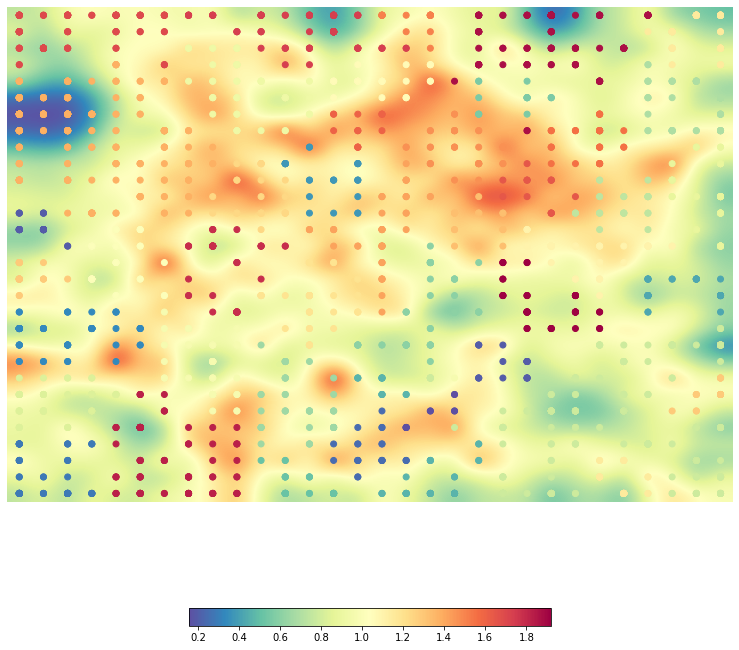

In [ ]:
algorithm = KMeans(n_clusters = 40)
som_30x30_2500.cluster(algorithm = algorithm)
som_30x30_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_30x30_40_2500 = som_30x30_2500.clusters

* Για set με 5000 ταινίες

In [ ]:
f_set_5000 = build_final_set(corpus_tf_idf_new_pca, 5000)

**Για χάρτη 20x20 με 100 epochs**

In [ ]:
n_rows, n_columns = 20, 20
som_20x20_5000 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_20x20_5000.train(f_set_5000, epochs = 100)

CPU times: user 12min 6s, sys: 2.92 s, total: 12min 9s
Wall time: 6min 26s


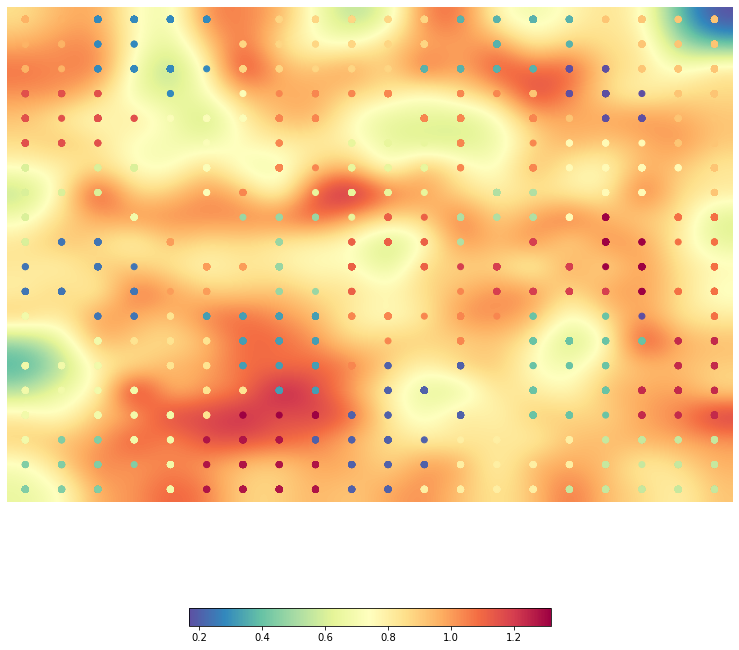

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_20x20_5000.cluster(algorithm = algorithm)
som_20x20_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_20x20_30_5000 = som_20x20_5000.clusters

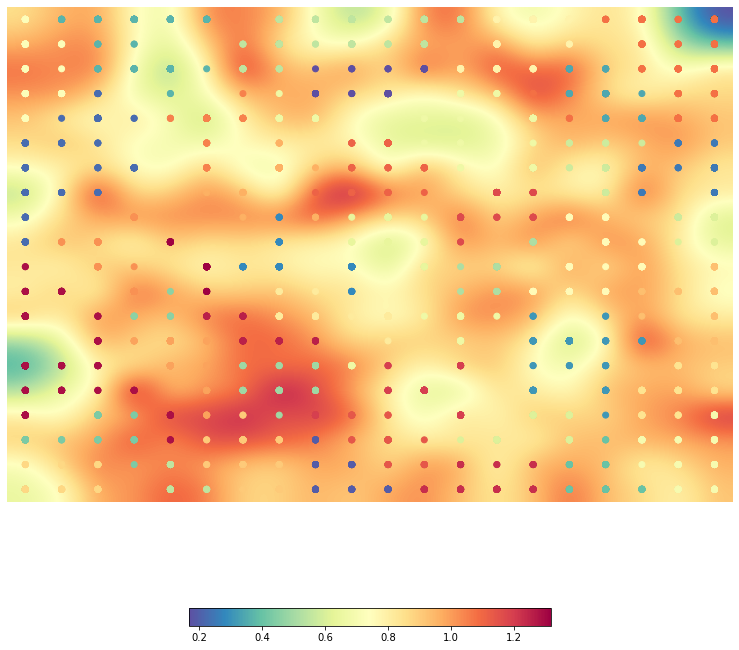

In [ ]:
algorithm = KMeans(n_clusters = 40)
som_20x20_5000.cluster(algorithm = algorithm)
som_20x20_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_20x20_40_5000 = som_20x20_5000.clusters

**Για χάρτη 30x30 με 100 epochs**

In [ ]:
n_rows, n_columns = 30, 30
som_30x30_5000 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_30x30_5000.train(f_set_5000, epochs = 100)

CPU times: user 27min 31s, sys: 6.81 s, total: 27min 38s
Wall time: 14min 33s


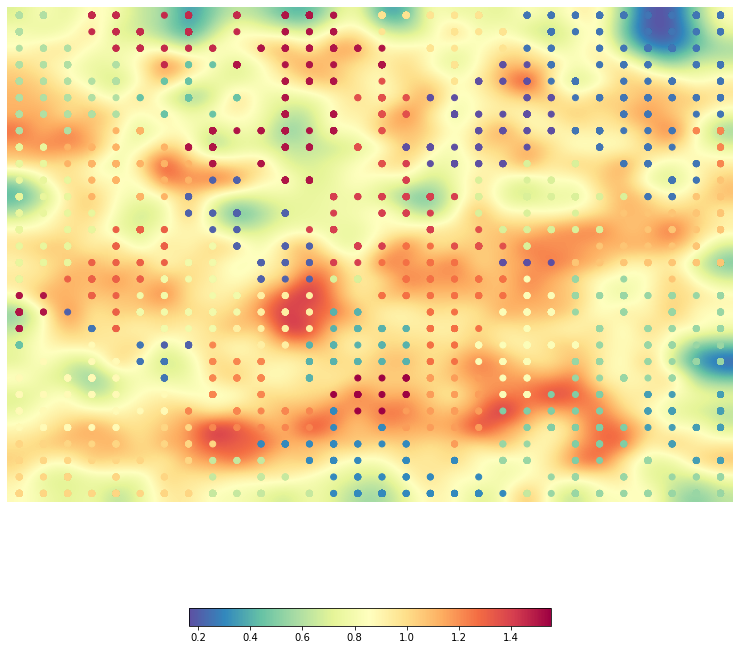

In [ ]:
algorithm = KMeans(n_clusters = 30)
som_30x30_5000.cluster(algorithm = algorithm)
som_30x30_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_30x30_30_5000 = som_30x30_5000.clusters

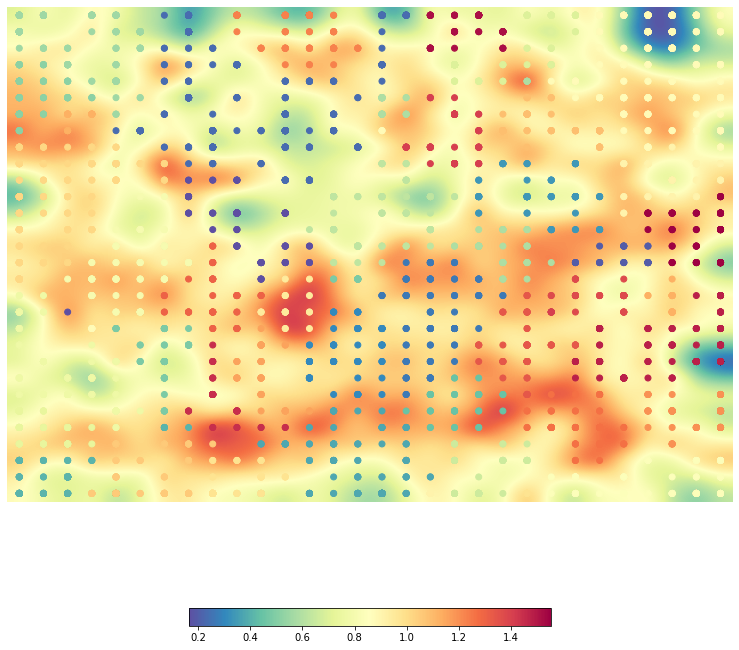

In [ ]:
algorithm = KMeans(n_clusters = 40)
som_30x30_5000.cluster(algorithm = algorithm)
som_30x30_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (13, 13))
clusters_30x30_40_5000 = som_30x30_5000.clusters

In [ ]:
bmus_5000 = som_20x20_5000.bmus
print(bmus_5000.shape)
ubmus_5000, indices_5000 = np.unique(bmus_5000, return_inverse = True, axis = 0)
#print(ubmus)
print(ubmus_5000.shape)
print(indices_5000)
print(indices_5000.shape)

(5000, 2)
(330, 2)
[  0   0 223 ...   7 145 310]
(5000,)


<font color = magenda>**Παρατηρήσεις**</font>

Έγιναν δοκιμές για όλους τους συνδυασμούς των παρακάτω παραμέτρων:
* Αριθμός ταινιών: 2500 και 5000
* Μεγέθη χάρτη SOM: 20x20 και 30x30
* Τιμές k: 30 και 40

Αρχικά ο χρόνος εκπαίδευσης αυξάνεται με την αύξηση των παραμέτρων.

Για τους χάρτες ιδίου μεγέθους, φαίνεται από την οπτική αναπαράσταση ότι η διαφορετικές τιμές του k αλλάζει το πόσο έντονα είναι τα χρώματα στο χάρτη, αλλά όχι την μορφή.

Αξίζει να σημειωθεί ότι όσο μεγαλύτερος ο χάρτης τόσο μεγαλύτερο πρέπει να είναι το k του k-means γιατί θα έχει περισσότερους νευρώνες που θα πρέπει να ομαδοποιηθούν. Παρ'όλα αυτά, εξαιρετικά μεγάλες τιμές του k μετά από ένα σημείο δημιουργούν προβλήματα συνοχής των επικρατέστερων κατηγοριών λόγω της δημιουργίας πολλών υποομάδων.

Παρατηρούμε ότι οι χάρτες 20x20 έχουν μεγάλες διαφορές με τους χάρτες 30x30.

Γενικότερα για τις 5000 ταινίες, καταλαβαίνουμε τις διαφορετικές περιοχές (πράσινες και κόκκινες) στον χάρτη 30x30 με k=40. Αυτόν τον χάρτη θα χρησιμοποιήσουμε για την μετέπειτα μελέτη.

Τα clusters για τον χάρτη 30x30 με k=40:

In [ ]:
print(clusters_30x30_40_5000)

[[11 11 11 11 11 11  2  2  2 30 30 30 30 30  2  2  2 38 38 38 38 15 15 15
  20 20 20 20 20 20]
 [11 11 11 11 11 11  2  2  2 30 30 30 30 30 30  2  2 38 38 38 38 15 15 15
  20 20 20 20 20 20]
 [11 11 11 11 11 11  2  2  2  2 30 30 30 30 30  2 38 38 38 38 38 15 15 15
  20 20 20 20 20 20]
 [10 10 11 11 11 11  2  2  2  2  2 30 30 30  2  2  2 15 15 15 15 15 15 20
  20 20 20 20 20 20]
 [10 10 10 11 11 11  2  2  2  2  2  2  2  2  2  2  2 15 15 15 15 12 20 20
  20 20 20 20 20 20]
 [10 10 10 10 11 11  2  2  2  2  2  2  2  2  2 12 12 35 35 35 26 26 26 20
  20 20 20 20 20 20]
 [10 10 27 27 11  2  2  2  2  2  2  2  2  2  2 12 12 35 35 35 26 26 26 26
  20 20 20 20 20 20]
 [10 10 27 27  2  2  2  2  2  2  2  2  2  2  2 20 12 35 35 35 26 26 26 26
  26 20 20 20 20 20]
 [24 24 24 24 24  2  2  2  2  2  2  2  2  2  2  2 35 35 35 35 35 26 26 26
  26 20 20 21 20 20]
 [24 24 24 24 24 24 24  2  2  2  2  2  2  2  2 13 13 35 35 35  5  5  5  5
  26 21 21 21 21 21]
 [24 24 24 24 24 24 24  0  0  0  0  2  2 13 13 13 

In [ ]:
k = 40
for i in range(k):
    print("Cluster id:", i)
    print("Number of movies in cluster is:", len(neuron_movies_report(som_30x30_5000,print_cluster_neurons_movies_report(i,som_30x30_5000,ubmus_5000))))
    print_categories_stats(neuron_movies_report(som_30x30_5000,print_cluster_neurons_movies_report(i,som_30x30_5000,ubmus_5000)))
    print('\n')

Cluster id: 0
Number of movies in cluster is: 114
Overall Cluster Genres stats:
[('"Thriller"', 114), ('"Mystery"', 31), ('"Crime Fiction"', 19), ('"Science Fiction"', 15), ('"World cinema"', 12), ('"Crime Thriller"', 10), ('"Adventure"', 9), ('"Comedy"', 7), ('"Family Film"', 5), ('"Erotic thriller"', 4), ('"Black-and-white"', 4), ('"Romance Film"', 4), ('"Action"', 4), ('"Indie"', 4), ('"Animation"', 3), ('"Spy"', 3), ('"Japanese Movies"', 3), ('"Film noir"', 2), ('"Fantasy"', 2), ('"Comedy film"', 2), ('"Musical"', 2), ('"Anime"', 2), ('"Supernatural"', 2), ('"Cult"', 2), ('"Computer Animation"', 1), ('"Courtroom Comedy"', 1), ('"Detective"', 1), ('"Crime Comedy"', 1), ('"Comedy Thriller"', 1), ('"Bollywood"', 1), ('"Black comedy"', 1), ('"Alien Film"', 1), ('"Film adaptation"', 1), ('"Disaster"', 1), ('"Psychological thriller"', 1), ('"Tokusatsu"', 1), ('"Time travel"', 1), ('"Television movie"', 1), ('"Steampunk"', 1), ('"Slasher"', 1), ('"Short Film"', 1), ('"Screwball comedy"', 

<font color = magenda>**Συνοπτική παρουσίαση σε markdown πίνακες αποτελεσμάτων κατηγοριοποίησης για το βέλτιστο χάρτη SOM για 5000 ταινίες**</font>



|Freq\Cluster ID|Cluster ID = 0|Cluster ID = 1|Cluster ID = 2|Cluster ID = 3|Cluster ID = 4|Cluster ID = 5|Cluster ID = 6|Cluster ID = 7|Cluster ID = 8|Cluster ID = 9|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**no1**|Thriller (114)|Family Film (33)|Short Film (98)|Action/Adventure (109)|Action (84)|Action (102)|Drama (158)|Romance Film (119)|Action/Adventure (41)|Thriller (83)|
|**no2**|Mystery (31)|Drama (33)|Comedy Film (66)|Action (106)|Thriller (83)|Drama (100)|World Cinema (158)|Drama (119)|World cinema (40)|Drama (83)|
|**no3**|Crime Fiction (19)|Comedy (33)|Silent Film (58)|Thriller (103)|Crime Fiction (80)|Crime Fiction (37)|Art Film (25)|Romantic Drama (118)|Action (37)|Mystery (17)|
|**no4**|Science Fiction (15)|Musical (8)|Japanese Movies (49)|Science Fiction (31)|Action/Adventure (68)|War Film (14)|Political Drama (17)|Period Piece (34)|Chinese Movies (33)|Action (15)|
|**no5**|World cinema (12)|Adventure (8)|Musical (29)|Action Thrillers (26)|Drama (60)|Adventure (13)|War Film (15)|Indie (24)|Martial Arts Film (32)|Science Fiction (9)|

|Freq\Cluster ID|Cluster ID = 10|Cluster ID = 11|Cluster ID = 12|Cluster ID = 13|Cluster ID = 14|Cluster ID = 15|Cluster ID = 16|Cluster ID = 17|Cluster ID = 18|Cluster ID = 19|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**no1**|Family Film (72)|Animation (188)|Action\Adventure (82)|Action (148)|World cinema (61)|Black-and-white (109)|Drama (58)|Romance Film (228)|Horror (112)|Comedy (179)|
|**no2**|Animation (65)|Short Film (133)|Western (51)|Thriller (38)|Comedy (50)|Drama (77)|Romance Film (58)|Drama (150)|Thriller (111)|Romance Film (129)|
|**no3**|Children's/Family (54)|Family Film (91)|Action (47)|Crime Fiction (26)|Drama (29)|Adventure (15)|Comedy (57)|Comedy (36)|Psychological Thriller (33)|Romantic comedy (112)| 
|**no4**|Adventure (50)|Comedy (58)|Drama (42)|Science Fiction (14)|Indie (9)|Crime Fiction (14)|Romantic comedy (53)|Comedy film (26)|Supernatural (31)|Musical (59)|
|**no5**|Fantasy (44)|Comedy Film (42)|Adventure (27)|Romance Film (13)|Japanese Movies (7)|Melodrama (12)|Comedy-drama (31)|Musical (20)|Mystery (30)|Indie (22)|

|Freq\Cluster ID|Cluster ID = 20|Cluster ID = 21|Cluster ID = 22|Cluster ID = 23|Cluster ID = 24|Cluster ID = 25|Cluster ID = 26|Cluster ID = 27|Cluster ID = 28|Cluster ID = 29|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**no1**|Drama (668)|Indie (84)|Thriller (20)|World cinema (75)|Horror (268)|World cinema (116)|Drama (79)|Fantasy (35)|Crime Thriller (54)|Comedy (105)|
|**no2**|Crime Fiction (60)|Drama (84)|Mystery (19)|Bollywood (74)|Science Fiction (63)|Drama (116)|Family Film (50)|Family Film (32)|Thriller (53)|Black-and-white (96)|
|**no3**|Period piece (48)|Family Drama (15)|Crime Thriller (18)|Musical (72)|Slasher (47)|Romance Film (115)|Adventure (48)|Comedy (24)|Crime Fiction (52)|Short Film (67)|
|**no4**|War film (43)|Crime Fiction (15)|Detective fiction (14)|Drama (52)|World cinema (31)|Romantic drama (110)|Family Drama(18)|Fantasy Comedy (12)|Drama (50)|Slapstick (18)|
|**no5**|Biographical film (33)|World cinema (13)|Detective (14)|Romance Film (35)|Cult (30)|Comedy (44)|Children's/Family (10)|Adventure (11)|Mystery (16)|Family Film (16)|

|Freq\Cluster ID|Cluster ID = 30|Cluster ID = 31|Cluster ID = 32|Cluster ID = 33|Cluster ID = 34|Cluster ID = 35|Cluster ID = 36|Cluster ID = 37|Cluster ID = 38|Cluster ID = 39|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|**no1**|Documentary (127)|Comedy (61)|Thriller (57)|Action (67)|Comedy (46)|Adventure (82)|Thriller (41)|Comedy (240)|Silent film (66)|Drama (126)|
|**no2**|Culture & Society (19)|Parody (60)|Phsychological thriller (52)|Comedy (67)|Family Film (45)|Action (51)|Crime Fiction (40)|Indie (29)|Black-and-white (58)|Comedy (124)|
|**no3**|Biography (16)|Satire (14)|Mystery (38)|Action/Adventure (56)|Adventure (17)|Black-and-white (16)|Drama (40)|Crime Fiction (19)|Drama (41)|Comedy-drama (43)|
|**no4**|Short Film (16)|Horror (14)|Crime thriller (34)|Crime Fiction (22)|Slapstick (9)|Fantasy (13)|Film noir (12)|Slapstick (19)|Indie (36)|Indie (39)|
|**no5**|History (12)|Science Fiction (11)|Suspense (30)|Adventure (13)|Teen (8)|Western (11)|Black-and-white (8)|Black comedy (15)|Short Film (14)|Black comedy (28)|



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


**1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.**

Για να απαντήσουμε στο ερώτημα, θα τυπώσουμε μια λίστα που θα περιέχει ζευγάρια με τις καtηγορίες των ταινιών και τον αριθμό των νευρώνων στους οποίους εμφανίζεται η κάθε κατηγορία.

In [ ]:
categories_stats = print_categories_stats([i for i in range(5000)])
most_frequent_categories = categories_stats[0:5]
least_frequent_categories = categories_stats[-10:]
print()
print("--------------------------------------------------------------------------------- \033[1m 5 most frequent categories \033[0m ---------------------------------------------------------------------------------")
for k in most_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(k[0],k[1]))
print("--------------------------------------------------------------------------------- \033[1m 10 least frequent categories \033[0m ---------------------------------------------------------------------------------")
for k in least_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(k[0],k[1]))
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
     

Overall Cluster Genres stats:
[('"Drama"', 2250), ('"Comedy"', 1281), ('"Romance Film"', 800), ('"Thriller"', 792), ('"Action"', 743), ('"World cinema"', 611), ('"Crime Fiction"', 539), ('"Horror"', 473), ('"Black-and-white"', 455), ('"Adventure"', 432), ('"Action/Adventure"', 428), ('"Family Film"', 408), ('"Indie"', 407), ('"Short Film"', 370), ('"Romantic drama"', 315), ('"Musical"', 307), ('"Science Fiction"', 286), ('"Animation"', 277), ('"Mystery"', 252), ('"Fantasy"', 246), ('"Romantic comedy"', 237), ('"Comedy film"', 208), ('"Crime Thriller"', 187), ('"War film"', 173), ('"Period piece"', 161), ('"Silent film"', 154), ('"Comedy-drama"', 150), ('"Documentary"', 145), ('"Japanese Movies"', 142), ('"Film adaptation"', 132), ('"Bollywood"', 131), ('"Psychological thriller"', 128), ('"Western"', 126), ('"Children\'s/Family"', 109), ('"Chinese Movies"', 107), ('"Parody"', 103), ('"Black comedy"', 102), ('"Sports"', 101), ('"Teen"', 93), ('"Martial Arts Film"', 93), ('"Family Drama"'

In [ ]:
neurons_categories_stats = []    
def number_of_neurons_in_category(category):
    count = 0
    for (i,_) in neurons_categories_stats:                     
        if i==category:                                   
           count+=1                                               
    return count                                                   


for i in range(30):  
    for j in range(30):                            
          neuron_IDs_list = neuron_movies_report(som_30x30_5000,[[i,j]])        
          neuron_categories_stats = print_categories_stats(neuron_IDs_list)     
          neurons_categories_stats.extend(neuron_categories_stats)

total_categories = []
for i in range(categories.shape[0]):                                         
    cat = [category.strip() for category in categories[i][0].split(",")]   
    total_categories.extend(cat)                                  
unique_categories = np.unique(total_categories)

final = []
for category in unique_categories:                                          
    final.append((category,number_of_neurons_in_category(category)))   
final_sorted = sorted(final, key=lambda x: x[1])                                

final = np.asarray(final_sorted)      
refinal = final[::-1]

In [ ]:
print(refinal[0:5])

[['"Drama"' '317']
 ['"Comedy"' '222']
 ['"Action"' '199']
 ['"Thriller"' '195']
 ['"Crime Fiction"' '158']]


Παρατηρούμε ότι από τις 5 πιο συχνές κατηγορίες στο SOM οι 4 από αυτές είναι και στις 5 κορυφαίες κατηγορίες σε αριθμό νευρώνων.

**2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.**

Παρουσιάζουμε παρακάτω σε σχόλιο το 30x30_40_5000.clusters ώστε να δούμε την χωροταξία του (κάτι που δεν φαίνεται λόγω μεγέθους εύκολα με το print).

In [ ]:
#  [11 11 11 11 11 11  2  2  2 30 30 30 30 30  2  2  2 38 38 38 38 15 15 15 20 20 20 20 20 20]
#  [11 11 11 11 11 11  2  2  2 30 30 30 30 30 30  2  2 38 38 38 38 15 15 15 20 20 20 20 20 20]
#  [11 11 11 11 11 11  2  2  2  2 30 30 30 30 30  2 38 38 38 38 38 15 15 15 20 20 20 20 20 20]
#  [10 10 11 11 11 11  2  2  2  2  2 30 30 30  2  2  2 15 15 15 15 15 15 20 20 20 20 20 20 20]
#  [10 10 10 11 11 11  2  2  2  2  2  2  2  2  2  2  2 15 15 15 15 12 20 20 20 20 20 20 20 20]
#  [10 10 10 10 11 11  2  2  2  2  2  2  2  2  2 12 12 35 35 35 26 26 26 20 20 20 20 20 20 20]
#  [10 10 27 27 11  2  2  2  2  2  2  2  2  2  2 12 12 35 35 35 26 26 26 26 20 20 20 20 20 20]
#  [10 10 27 27  2  2  2  2  2  2  2  2  2  2  2 20 12 35 35 35 26 26 26 26 26 20 20 20 20 20]
#  [24 24 24 24 24  2  2  2  2  2  2  2  2  2  2  2 35 35 35 35 35 26 26 26 26 20 20 21 20 20]
#  [24 24 24 24 24 24 24  2  2  2  2  2  2  2  2 13 13 35 35 35  5  5  5  5 26 21 21 21 21 21]
#  [24 24 24 24 24 24 24  0  0  0  0  2  2 13 13 13 13 13 35  5  5  5  5  5  5 21 21 21 21 21]
#  [24 24 24 24 24 18 18  0  0  0  0  0 13 13 13 13 13 13 13  5  5  5  5  5  5 21 21 21 21 39]
#  [24 24 24 24 18 18  0  0  0  0  0  0  0 13 13 13 13 13 13  5  5  5  5  5  5 21 39 39 39 39]
#  [24 24 24 24 18 18 18  0  0  0  0  0 13 13 13 13 13 13 13 12 12 12  5  5  5  1 39 39 39 39]
#  [24 24 24 24 18 18 18 18 32  0  0  0  0 13 13 13 13 13 12 12 12 12 12  1  1  1  1 39 39 39]
#  [24 24 24 18 18 18 18 18 32  0  0  0  0 13 13 13  3  3  3 12 12 12 12  1  1  1  1 39 39 39]
#  [24 24 18 18 18 18 18 32 32 32  0 22 22  9  9  9  3  3  3  3 12 12 34 34 34 34  1 27 39 39]
#  [17 17 18 18 18 18 32 32 32 32 32 22 22  4  9  3  3  3  3  3  3 33 34 34 34 34 27 27 37 37]
#  [17 17  0 18 18 18 32 32 32 32 22 22 22  4  4  3  3  3  3  3 33 33 35 34 34 34 37 27 37 37]
#  [17 17 20 20  9  9  9  9 32 32 28 22 22  4  4  4  3  3  3  3 33 33 33 37 37 37 37 37 37 37]
#  [17 17 17 17  9  9  9  9 36 28 28 28  4  4  4  4  3  3  3 33 33 33 33 33 37 37 37 37 37 37]
#  [17 17 17 17 17  9  9  9 36 28 28 28  4  4  4  4  3  3  3 33 33 33 33 37 37 37 37 37 37 37]
#  [17 17 17 17 17  9  9  9 36 28 28 28  4  4  4  4  3  3  8  8 33 33 33 37 37 37 37 37 37 37]
#  [17 17 17 17 17 17  9 36 36 36 28 28 36  4  4  4  3  8  8  8  8 33 31 31 31 37 29 29 29 29]
#  [16 16 16 17 17 17  9 36 36 36 28 28 28  6  6  6  8  8  8  8  8 31 31 31 31 29 29 29 29 29]
#  [16 16 16 16 17  7  7  7 36 36 36 36  6  6  6  6  6  8  8  8 14 31 31 31 31 31 29 29 29 29]
#  [16 16 16 16 25 25 25 25 25 36  6  6  6  6  6  6  6  6 14 14 14 14 31 31 31 31 19 29 29 29]
#  [ 7  7  7  7 25 25 25 25 23 23 23  6  6  6  6  6  6  6 14 14 14 14 14 31 31 19 19 19 19 19]
#  [ 7  7  7  7 25 25 25 25 23 23 23 23  6  6  6  6  6  6 14 14 14 14 19 19 19 19 19 19 19 19]
#  [ 7  7  7 25 25 25 25 25 23 23 23 23  6  6  6  6  6 21 14 14 14 23 19 19 19 19 19 19 19 19]

In [ ]:
cluster = 19
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Comedy"', 179), ('"Romance Film"', 129), ('"Romantic comedy"', 112), ('"Musical"', 59), ('"Indie"', 22), ('"Black-and-white"', 21), ('"Musical comedy"', 14), ('"Teen"', 9), ('"Screwball comedy"', 8), ('"Comedy-drama"', 8), ('"Family Film"', 8), ('"Slapstick"', 7), ('"Comedy of manners"', 6), ('"World cinema"', 6), ('"Action"', 6), ('"Comedy of Errors"', 5), ('"Black comedy"', 5), ('"Sex comedy"', 5), ('"Ensemble Film"', 5), ('"Television movie"', 4), ('"Fantasy"', 4), ('"Workplace Comedy"', 3), ('"Adventure"', 3), ('"Satire"', 3), ('"Coming of age"', 3), ('"Cult"', 3), ('"Science Fiction"', 3), ('"Sports"', 3), ('"Domestic Comedy"', 3), ('"Political cinema"', 3), ('"Parody"', 3), ('"Mockumentary"', 2), ('"Western"', 2), ('"Comedy film"', 2), ('"Crime Fiction"', 2), ('"Children\'s/Family"', 2), ('"Children\'s"', 2), ('"Buddy film"', 2), ('"Romantic drama"', 2), ('"Thriller"', 2), ('"Music"', 2), ('"Road movie"', 2), ('"Action/Adventure"', 2), ('"Remake"

In [ ]:
cluster = 38
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Silent film"', 66), ('"Black-and-white"', 58), ('"Drama"', 41), ('"Indie"', 36), ('"Short Film"', 14), ('"Adventure"', 5), ('"Comedy"', 4), ('"Science Fiction"', 4), ('"Fantasy"', 3), ('"Crime Fiction"', 3), ('"Romance Film"', 3), ('"Melodrama"', 3), ('"Biography"', 2), ('"Documentary"', 2), ('"World cinema"', 2), ('"Western"', 2), ('"Horror"', 1), ('"Gangster Film"', 1), ('"Film adaptation"', 1), ('"Japanese Movies"', 1), ('"Pre-Code"', 1), ('"Romantic drama"', 1), ('"Comedy-drama"', 1), ('"Sports"', 1), ('"Stop motion"', 1), ('"Thriller"', 1), ('"Biographical film"', 1), ('"War film"', 1), ('"Action"', 1)]


Βλέπουμε για παράδειγμα το cluster 19 που βρίσκεται κάτω δεξιά έχει ως επι το πλέιστον είδη Comedy, Romance Film, Romantic Comedy, Musical. Το cluster 38 που βρίσκεται πάνω στην μέση και έχει ως επί το πλείστον είδη Silent Film, Black-and-white, Drama, Indie. Οι κατηγoρίες αυτές απέχουν πολύ νοηματικά και γιαυτό είναι και τα clusters μακριά χωροταξιακά.

**3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.**

In [ ]:
cluster = 16
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Drama"', 58), ('"Romance Film"', 58), ('"Comedy"', 57), ('"Romantic comedy"', 53), ('"Comedy-drama"', 31), ('"Romantic drama"', 22), ('"Indie"', 16), ('"Coming of age"', 6), ('"Ensemble Film"', 5), ('"Domestic Comedy"', 4), ('"Buddy film"', 4), ('"Family Drama"', 4), ('"Film adaptation"', 4), ('"Slice of life story"', 4), ('"Black comedy"', 3), ('"Screwball comedy"', 3), ('"Comedy of manners"', 3), ('"Musical"', 3), ('"Black-and-white"', 3), ('"Fantasy"', 2), ('"Workplace Comedy"', 2), ('"Crime Fiction"', 2), ('"Period piece"', 2), ('"Parody"', 2), ('"Road movie"', 2), ('"Slapstick"', 2), ('"Teen"', 2), ('"Biography"', 1), ('"Costume drama"', 1), ('"Animation"', 1), ('"Adventure"', 1), ('"Cult"', 1), ('"Action/Adventure"', 1), ('"Zombie Film"', 1), ('"Horror"', 1), ('"Family Film"', 1), ('"Feminist Film"', 1), ('"Horror Comedy"', 1), ('"Marriage Drama"', 1), ('"Media Satire"', 1), ('"Mumblecore"', 1), ('"Mystery"', 1), ('"Religious Film"', 1), ('"Roman

In [ ]:
cluster = 17
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Romance Film"', 228), ('"Drama"', 150), ('"Comedy"', 36), ('"Comedy film"', 26), ('"Musical"', 20), ('"Black-and-white"', 15), ('"Family Film"', 11), ('"Crime Fiction"', 8), ('"Film adaptation"', 8), ('"Adventure"', 7), ('"Action"', 6), ('"World cinema"', 5), ('"War film"', 4), ('"Fantasy"', 4), ('"Historical fiction"', 4), ('"Sports"', 3), ('"Silent film"', 3), ('"Chinese Movies"', 3), ('"Science Fiction"', 3), ('"Melodrama"', 3), ('"Roadshow theatrical release"', 2), ('"Cult"', 2), ('"Family Drama"', 2), ('"Bollywood"', 2), ('"Western"', 2), ('"Horror"', 2), ('"Indie"', 2), ('"Japanese Movies"', 2), ('"Backstage Musical"', 2), ('"Mystery"', 2), ('"Costume drama"', 2), ('"Blaxploitation"', 1), ('"Thriller"', 1), ('"Biopic [feature]"', 1), ('"Buddy film"', 1), ('"Biography"', 1), ('"Biographical film"', 1), ('"Caper story"', 1), ('"Avant-garde"', 1), ('"Animation"', 1), ('"Tamil cinema"', 1), ('"Experimental film"', 1), ('"Coming of age"', 1), ('"Crime

Βλέπουμε για παράδειγμα τα clusters 16 και 17 έχουν ως πρώτα είδη Drama, Romance Film, Comedy. Τα clusters αυτά είναι κοντά χωροταξιακά και παρατηρούμε ότι έχουν και πολύ κοινά είδη.

**4. Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.**

In [ ]:
cluster = 2
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Short Film"', 98), ('"Comedy film"', 66), ('"Silent film"', 58), ('"Japanese Movies"', 49), ('"Musical"', 29), ('"Science Fiction"', 29), ('"Crime Fiction"', 27), ('"Chinese Movies"', 21), ('"Western"', 19), ('"War film"', 18), ('"Mystery"', 17), ('"Romantic comedy"', 14), ('"Fantasy"', 13), ('"Comedy-drama"', 12), ('"Indie"', 11), ('"Family Film"', 10), ('"Biographical film"', 9), ('"Martial Arts Film"', 9), ('"Anime"', 7), ('"Bollywood"', 6), ('"Historical drama"', 6), ('"Adventure"', 6), ('"Romantic drama"', 5), ('"Filipino Movies"', 4), ('"Parody"', 4), ('"Detective"', 4), ('"Historical fiction"', 4), ('"Animated cartoon"', 4), ('"Art film"', 4), ('"Propaganda film"', 3), ('"Children\'s/Family"', 3), ('"Action/Adventure"', 3), ('"Animation"', 3), ('"Black-and-white"', 3), ('"Children\'s"', 3), ('"Film noir"', 3), ('"Comedy"', 3), ('"Computer Animation"', 3), ('"Detective fiction"', 3), ('"Cult"', 2), ('"History"', 2), ('"Drama"', 2), ('"Black comed

In [ ]:
cluster = 27
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Fantasy"', 35), ('"Family Film"', 32), ('"Comedy"', 24), ('"Fantasy Comedy"', 12), ('"Adventure"', 11), ('"Science Fiction"', 6), ('"Heavenly Comedy"', 6), ('"Romance Film"', 5), ('"Religious Film"', 4), ('"Romantic comedy"', 4), ('"Domestic Comedy"', 4), ('"Children\'s/Family"', 4), ('"Comedy film"', 3), ('"Black comedy"', 3), ('"Sports"', 3), ('"Romantic fantasy"', 3), ('"Musical"', 3), ('"Horror"', 2), ('"Satire"', 2), ('"Christmas movie"', 2), ('"Parody"', 2), ('"Children\'s"', 2), ('"Buddy film"', 1), ('"Drama"', 1), ('"Animation"', 1), ('"Comedy-drama"', 1), ('"Costume drama"', 1), ('"Alien Film"', 1), ('"World cinema"', 1), ('"Heaven-Can-Wait Fantasies"', 1), ('"Ealing Comedies"', 1), ('"Family-Oriented Adventure"', 1), ('"Fantasy Adventure"', 1), ('"War film"', 1), ('"Holiday Film"', 1), ('"Indie"', 1), ('"Short Film"', 1), ('"Slapstick"', 1), ('"Sword and sorcery films"', 1), ('"Sword and sorcery"', 1), ('"Teen"', 1), ('"Thriller"', 1), ('"Tim

To cluster 2 είναι το μεγαλύτερο και το cluster 27 είναι το μικρότερο και βρίσκονται δίπλα στον χάρτη. Δεν εμφανίζουν πολύ μεγάλη ομοιότητα στα είδη.

In [ ]:
cluster = 1
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Family Film"', 33), ('"Drama"', 33), ('"Comedy"', 33), ('"Musical"', 8), ('"Adventure"', 8), ('"Family Drama"', 6), ('"Children\'s/Family"', 6), ('"Fantasy"', 5), ('"Children\'s"', 5), ('"Television movie"', 4), ('"Sports"', 4), ('"Comedy-drama"', 3), ('"Black-and-white"', 2), ('"Musical comedy"', 2), ('"Childhood Drama"', 2), ('"Teen"', 2), ('"Coming of age"', 1), ('"Children\'s Fantasy"', 1), ('"Biopic [feature]"', 1), ('"Biographical film"', 1), ('"Animal Picture"', 1), ('"Christmas movie"', 1), ('"Action/Adventure"', 1), ('"Action"', 1), ('"Caper story"', 1), ('"Western"', 1), ('"Dance"', 1), ('"Thriller"', 1), ('"Family-Oriented Adventure"', 1), ('"Film adaptation"', 1), ('"Hip hop movies"', 1), ('"Melodrama"', 1), ('"Musical Drama"', 1), ('"Period piece"', 1), ('"Remake"', 1), ('"Romance Film"', 1), ('"Romantic comedy"', 1), ('"Satire"', 1), ('"Short Film"', 1), ('"Slapstick"', 1), ('"Spy"', 1), ('"Action Comedy"', 1)]


In [ ]:
cluster = 39    # ελέγχουμε και τα 5,12,27,34
cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)

Overall Cluster Genres stats:
[('"Drama"', 126), ('"Comedy"', 124), ('"Comedy-drama"', 43), ('"Indie"', 39), ('"Black comedy"', 28), ('"Film adaptation"', 16), ('"Satire"', 11), ('"Parody"', 10), ('"Crime Fiction"', 9), ('"Coming of age"', 8), ('"Fantasy"', 8), ('"Period piece"', 8), ('"Black-and-white"', 7), ('"Cult"', 7), ('"Road movie"', 6), ('"Ensemble Film"', 5), ('"Adventure"', 5), ('"Buddy film"', 5), ('"Sports"', 5), ('"Romance Film"', 5), ('"Science Fiction"', 4), ('"Experimental film"', 4), ('"Political drama"', 3), ('"Teen"', 3), ('"Avant-garde"', 3), ('"Domestic Comedy"', 3), ('"Thriller"', 3), ('"Short Film"', 3), ('"Fantasy Comedy"', 2), ('"Family Drama"', 2), ('"Comedy of manners"', 2), ('"Tragicomedy"', 2), ('"War film"', 2), ('"Marriage Drama"', 2), ('"Political cinema"', 2), ('"Surrealism"', 2), ('"Stoner film"', 2), ('"Silent film"', 2), ('"Romantic comedy"', 2), ('"Political satire"', 2), ('"Biographical film"', 2), ('"Mockumentary"', 2), ('"Musical"', 2), ('"Auto r

Για το cluster 1 κανένα από τα διπλανά clusters 5,12,27,34,39 δεν έχει ως πρώτο είδος το Family Film που είναι πρώτο για το cluster 1.

**5. Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.**

Βρίσκουμε ένα σημείο στο χάρτη στη μέση (το πιο adventurous) που όλα τα κοντινα clusters έχουν ως πρώτο είδος Action/Adventure.

In [ ]:
for cluster in [5,12,13,35]:
  print("Cluster:",cluster)
  cluster_coordinates = print_cluster_neurons_movies_report(cluster,som_30x30_5000,ubmus_5000)
  cluster_movies_ids = neuron_movies_report(som_30x30_5000,cluster_coordinates)
  cluster_category_stats = print_categories_stats(cluster_movies_ids)
  print()

Cluster: 5
Overall Cluster Genres stats:
[('"Action"', 102), ('"Drama"', 100), ('"Crime Fiction"', 37), ('"War film"', 14), ('"Adventure"', 13), ('"Action/Adventure"', 11), ('"Martial Arts Film"', 8), ('"Family Film"', 8), ('"Romance Film"', 7), ('"Chinese Movies"', 7), ('"Comedy"', 6), ('"Combat Films"', 5), ('"Sports"', 5), ('"Mystery"', 5), ('"History"', 4), ('"Indie"', 4), ('"Comedy film"', 4), ('"Period piece"', 3), ('"Coming of age"', 3), ('"Black-and-white"', 3), ('"Television movie"', 2), ('"Docudrama"', 2), ('"Political drama"', 2), ('"Musical"', 2), ('"Film noir"', 2), ('"Blaxploitation"', 2), ('"Black comedy"', 2), ('"Biographical film"', 2), ('"Albino bias"', 1), ('"Boxing"', 1), ('"Buddy film"', 1), ('"Chase Movie"', 1), ('"Addiction Drama"', 1), ('"Biography"', 1), ('"Bollywood"', 1), ('"Documentary"', 1), ('"Crime Comedy"', 1), ('"Historical drama"', 1), ('"Prison"', 1), ('"Prison film"', 1), ('"Political thriller"', 1), ('"Melodrama"', 1), ('"Japanese Movies"', 1), ('"H


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>